# Setup ToyData

In [1]:
class ToyData:

    def __init__(self):

        self.attributes = {'color':['y', 'g', 'b'], 'size':['s','l'], 'shape':['r', 'i']}
        self.classes = ('+', '-')

        self.data = [('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('g', 's', 'i'),
                 ('g', 'l', 'i'),
                 ('y', 'l', 'r'),
                 ('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('g', 's', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 'l', 'r'),
                 ('y', 's', 'i'),
                 ('y', 'l', 'i')]
        self.target = ('+', '-', '+', '-', '+', '+', '+', '+', '-', '-', '+', '-', '-', '-', '+', '+')

        self.testData = [('y', 's', 'r'),
                 ('y', 's', 'r'),
                 ('g', 's', 'i'),
                 ('g', 'l', 'i'),
                 ('y', 'l', 'r')]

        self.testTarget = ('+', '-', '+', '-', '+')

    def get_data(self):
        return self.attributes, self.classes, self.data, self.target, self.testData, self.testTarget



# Implement decision tree classifier based on the ID3 algorithm

In [2]:
from collections import Counter
from graphviz import Digraph


In [3]:
class ID3DecisionTreeClassifier :
    def __init__(self, minSamplesLeaf = 1, minSamplesSplit = 2, inequality = False) :
        
        self.attr_index = {}
        self.__nodeCounter = 0
        self.inequality = inequality
        # the graph to visualise the tree
        self.__dot = Digraph(comment='The Decision Tree')

        # suggested attributes of the classifier to handle training parameters
        self.__minSamplesLeaf = minSamplesLeaf
        self.__minSamplesSplit = minSamplesSplit


    # Create a new node in the tree with the suggested attributes for the visualisation.
    # It can later be added to the graph with the respective function
    def new_ID3_node(self):
        node = {'id': self.__nodeCounter, 'label': None, 'attribute': None, 'entropy': None, 'samples': None,
                         'classCounts': None, 'nodes': None}

        self.__nodeCounter += 1
        return node

    # adds the node into the graph for visualisation (creates a dot-node)
    def add_node_to_graph(self, node, parentid=-1):
        nodeString = ''
        for k in node:
            if ((node[k] != None) and (k != 'nodes')):
                nodeString += "\n" + str(k) + ": " + str(node[k])

        self.__dot.node(str(node['id']), label=nodeString)
        if (parentid != -1):
            self.__dot.edge(str(parentid), str(node['id']))

    # make the visualisation available
    def make_dot_data(self) :
        return self.__dot

    # For you to fill in; Suggested function to find the best attribute to split with, given the set of
    # remaining attributes, the currently evaluated data and target.
    def find_split_attr(self, data,target,attributes,classes):
        max_info_gain = None
        for attr in attributes:
            remaining_attr = self.removekey(attributes,attr)
            i_gain, ent = self.info_gain(attr, data,target,attributes,classes)
            if max_info_gain is None or i_gain > max_info_gain:
                max_info_gain = i_gain
                max_info_gain_attr = attr
                
        return max_info_gain_attr, ent
    
    # removes key
    def removekey(self, d, key):
        r = dict(d)
        del r[key]
        return r
    
    def entropy_split(self,data,target,col,val):
        cnt = Counter()
        
        for i in range(len(data)):
            if self.inequality:
                if data[i][col] in val:
                    cnt[target[i]] += 1
            else:
                if data[i][col] == val:
                    cnt[target[i]] += 1
            
        n_v = len(list(cnt.elements()))
        ent_v = 0
        if n_v > 0:
            for cl in classes:
                p_x = cnt[cl]/n_v
                if p_x != 0:
                    ent_v += -p_x*math.log(p_x,2)
        return ent_v, n_v
    
    def info_gain(self,split, data,target,attributes,classes):
        # Calculate the entropy first
        entropy = 0
        cnt = Counter(target)
        n = len(target)
        
        for cl in classes:
            p_x = cnt[cl]/n
            if p_x != 0:
                entropy += - p_x * math.log(p_x,2)
        
        col = self.attr_index[split]
        info_gain = entropy
        for val in attributes[split]:
            ent_v, n_v = self.entropy_split(data,target, col, val)
            info_gain += - n_v/n*ent_v
            
        return info_gain, entropy
            
                
    # Use this function split the data acording to the split attribute
    # Return values are dicts with value of split attribute as keys and the data/targets as items.
    def find_data_split(self,data,target,attributes,classes,split):
        data_split = {}
        target_split = {}
        col = self.attr_index[split]
        for vals in attributes[split]:
            data_split[str(vals)] = []
            target_split[str(vals)] = []
            for i in range(len(target)):
                if self.inequality:
                    if data[i][col] in vals:
                        data_split[str(vals)].append(data[i])
                        target_split[str(vals)].append(target[i])
                else:
                    if data[i][col] == vals:
                        data_split[str(vals)].append(data[i])
                        target_split[str(vals)].append(target[i])
                   
        return data_split, target_split
        

    # the entry point for the recursive ID3-algorithm, you need to fill in the calls to your recursive implementation
    def fit(self, data, target, attributes, classes, parent_id = -1):
        if self.__nodeCounter == 0:
            for attr in attributes:
                self.attr_index[attr] = list(attributes.keys()).index(attr)
                
        node = self.new_ID3_node()
#         self.add_node_to_graph(node)
        cnt = Counter(target)
        node['samples'] = len(target)
        node['classCounts'] = cnt
        if len(cnt) == 1:
            node['label'] = target[0]
            self.add_node_to_graph(node,parent_id)
            return node
        
        elif len(attributes) == 0:
            node['label'] = cnt.most_common(1)[0][0]
            self.add_node_to_graph(node, parent_id)
            return node
        else:
            split,ent = self.find_split_attr(data,target,attributes,classes)
            node['nodes'] = {}
            node['entropy'] = ent
            node['attribute'] = split
            fit_data, fit_target = self.find_data_split(data,target,attributes,classes,split)    
            for vals in attributes[split]:
                if len(fit_target[str(vals)]) == 0:
                    leaf_node = self.new_ID3_node()
                    leaf_node['label'] = cnt.most_common(1)[0][0]
                    leaf_node['samples'] = 0
                    self.add_node_to_graph(leaf_node,int(node['id']))
                    node['nodes'][str(vals)] = leaf_node
                else:
                    remaining_attr = self.removekey(attributes, split)
                    node['nodes'][str(vals)] = self.fit(fit_data[str(vals)],fit_target[str(vals)],remaining_attr,classes, int(node['id']))

        # fill in something more sensible here..  root should become the output of the recursive tree creation
        # root = self.new_ID3_node()
        # self.add_node_to_graph(root)
        self.add_node_to_graph(node, parent_id)
        return node
    

    def predict(self, data, tree) :
        predicted = list()
        
        def traverse(one_data, node):
            if node['label'] is not None:
                return node['label']
            elif node['nodes'] is not None:
                attr = node['attribute']
                val = one_data[self.attr_index[attr]]  
                if self.inequality:
                    for vals in node['nodes']:
                        if val in eval(vals):
                            return traverse(one_data, node['nodes'][str(vals)])
                        
                else:
                    return traverse(one_data,node['nodes'][str(val)])
                
            
        for i in range(len(data)):
            predicted.append(traverse(data[i],tree))
            

        # fill in something more sensible here... root should become the output of the recursive tree creation
        return predicted

# Run the ID3 classifier

In [4]:
# import ToyData as td
# import ID3

import numpy as np
import math
from sklearn import tree, metrics, datasets


In [5]:
attributes, classes, data, target, data2, target2 = ToyData().get_data()

id3 = ID3DecisionTreeClassifier()

myTree = id3.fit(data, target, attributes, classes)
print(myTree)
plot = id3.make_dot_data()
plot.render("testTree")
predicted = id3.predict(data2, myTree)
print(predicted)

{'id': 0, 'label': None, 'attribute': 'size', 'entropy': 0.9886994082884974, 'samples': 16, 'classCounts': Counter({'+': 9, '-': 7}), 'nodes': {'s': {'id': 1, 'label': None, 'attribute': 'shape', 'entropy': 0.8112781244591328, 'samples': 8, 'classCounts': Counter({'+': 6, '-': 2}), 'nodes': {'r': {'id': 2, 'label': None, 'attribute': 'color', 'entropy': 0.9182958340544896, 'samples': 6, 'classCounts': Counter({'+': 4, '-': 2}), 'nodes': {'y': {'id': 3, 'label': '+', 'attribute': None, 'entropy': None, 'samples': 5, 'classCounts': Counter({'+': 4, '-': 1}), 'nodes': None}, 'g': {'id': 4, 'label': '-', 'attribute': None, 'entropy': None, 'samples': 1, 'classCounts': Counter({'-': 1}), 'nodes': None}, 'b': {'id': 5, 'label': '+', 'attribute': None, 'entropy': None, 'samples': 0, 'classCounts': None, 'nodes': None}}}, 'i': {'id': 6, 'label': '+', 'attribute': None, 'entropy': None, 'samples': 2, 'classCounts': Counter({'+': 2}), 'nodes': None}}}, 'l': {'id': 7, 'label': None, 'attribute': 

In [6]:
print(predicted)
print(target2)

['+', '+', '+', '-', '-']
('+', '-', '+', '-', '+')


In [20]:
print("Classification report for classifier : \n", metrics.classification_report(target2, predicted))

Classification report for classifier : 
               precision    recall  f1-score   support

           +       0.67      0.67      0.67         3
           -       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



In [8]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(target2, predicted))

Confusion matrix:
[[2 1]
 [1 1]]


# ID3 classifier with digits dataset

In [9]:
from sklearn import datasets,metrics
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [10]:
digits = datasets.load_digits()
# digits.data

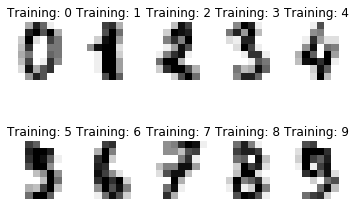

In [11]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [12]:
num_examples = len(digits.data)
num_split = int(0.7*num_examples)
train_features = digits.data[:num_split]
train_labels =  digits.target[:num_split]
test_features = digits.data[num_split:]
test_labels = digits.target[num_split:]

In [13]:
print("Number of training examples: ",len(train_features))
print("Number of test examples: ",len(test_features))
print("Number of total examples:", len(train_features)+len(test_features))

Number of training examples:  1257
Number of test examples:  540
Number of total examples: 1797


In [14]:
classifier = DecisionTreeClassifier(min_samples_leaf = 1)
classifier.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
id3_2 = ID3DecisionTreeClassifier()

classes = [i for i in range(10)]
attributes = {}
for i in range(64):
    attributes[i] = [float(j) for j in range(17)]
my2Tree = id3_2.fit(train_features, train_labels,attributes,classes)


In [26]:
plot = id3_2.make_dot_data()
plot.render("digitsTree")

'digitsTree.pdf'

In [16]:
predicted2 = id3_2.predict(test_features, my2Tree)

In [19]:
print("Classification report for classifier : \n", metrics.classification_report(test_labels, predicted2))

Classification report for classifier : 
               precision    recall  f1-score   support

           0       0.48      0.57      0.52        53
           1       0.14      0.11      0.12        53
           2       0.50      0.64      0.56        53
           3       0.54      0.68      0.60        53
           4       0.47      0.44      0.45        57
           5       0.21      0.18      0.19        56
           6       0.45      0.46      0.46        54
           7       0.24      0.19      0.21        54
           8       0.25      0.25      0.25        52
           9       0.56      0.51      0.53        55

    accuracy                           0.40       540
   macro avg       0.38      0.40      0.39       540
weighted avg       0.38      0.40      0.39       540



In [207]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, predicted2))

Confusion matrix:
[[30  4  0  0  4  3  8  2  1  1]
 [ 1  6  9  4  3  6  5  3  9  7]
 [ 1  4 34  5  0  2  0  2  3  2]
 [ 1  2  3 36  1  2  0  3  5  0]
 [ 6  3  1  0 25  6  9  2  1  4]
 [10  3  2  6  7 10  3  6  7  2]
 [ 5  7  0  1  5  1 25  5  4  1]
 [ 3  6  8  0  7  8  1 10  6  5]
 [ 4  7  9  2  1  6  4  6 13  0]
 [ 1  1  2 13  0  4  0  3  3 28]]


In [21]:
inequality = True
id3_3 = ID3DecisionTreeClassifier(inequality = True)
attributes = {}
for i in range(64):
    attributes[i] = list()
    attributes[i].append([float(j) for j in range(5)])
    attributes[i].append([float(j+5) for j in range(7)])
    attributes[i].append([float(j+12) for j in range(5)])
my3Tree = id3_3.fit(train_features, train_labels, attributes, classes)

In [216]:
plot = id3_3.make_dot_data()
plot.render("digitsTree_DGL")

'digitsTree_DGL.pdf'

In [22]:
predicted3 = id3_3.predict(test_features, my3Tree)

In [23]:
print("Classification report for classifier : \n", metrics.classification_report(test_labels, predicted3))

Classification report for classifier : 
               precision    recall  f1-score   support

           0       0.93      0.94      0.93        53
           1       0.66      0.77      0.71        53
           2       0.83      0.64      0.72        53
           3       0.85      0.75      0.80        53
           4       0.77      0.82      0.80        57
           5       0.76      0.79      0.77        56
           6       0.80      0.87      0.83        54
           7       0.72      0.80      0.75        54
           8       0.65      0.62      0.63        52
           9       0.88      0.78      0.83        55

    accuracy                           0.78       540
   macro avg       0.78      0.78      0.78       540
weighted avg       0.78      0.78      0.78       540



In [24]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, predicted3))

Confusion matrix:
[[50  1  0  0  0  1  1  0  0  0]
 [ 0 41  0  1  3  1  2  1  3  1]
 [ 1  1 34  3  0  1  3  1  6  3]
 [ 0  2  1 40  1  4  0  3  1  1]
 [ 2  1  0  0 47  0  4  3  0  0]
 [ 0  3  1  0  3 44  0  4  1  0]
 [ 0  6  0  0  0  0 47  0  1  0]
 [ 0  1  0  1  1  4  0 43  3  1]
 [ 0  4  5  0  4  3  2  2 32  0]
 [ 1  2  0  2  2  0  0  3  2 43]]


# Accuracy metrics (ska detta ens göras?)

In [102]:
def getMetrics(TP,FP,TN,FN):
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    f1 = 2*precision*recall/(precision+recall)
    return precision, recall, accuracy, f1

def metricsReport(target, predictions,classes):
    print("\t Precision \t\t Recall \t\t accuracy \t\t f1-score" )
    for cl in classes:
        FP = 0
        TP = 0
        TN = 0
        FN = 0
        for i in range(len(predictions)):
            if target[i] == predictions[i]:
                if predictions[i] == cl:
                    TP += 1
                else:
                    FN += 1
            else:
                if predictions[i] == cl:
                    FP += 1
                else:
                    TN += 1
        pre, re, acc, f1 = getMetrics(TP,FP,TN,FN)
        print(cl,"\t",pre, "\t",re, "\t",acc, "\t",f1)
        
            
                

In [103]:
metricsReport(test_labels, predicted3, classes)


	 Precision 		 Recall 		 accuracy 		 f1-score
0 	 0.8292682926829268 	 0.44155844155844154 	 0.9074074074074074 	 0.576271186440678
1 	 0.7142857142857143 	 0.06493506493506493 	 0.8629629629629629 	 0.11904761904761903
2 	 0.5454545454545454 	 0.07792207792207792 	 0.8592592592592593 	 0.13636363636363635
3 	 0.5 	 0.05194805194805195 	 0.8574074074074074 	 0.09411764705882353
4 	 0.1111111111111111 	 0.012987012987012988 	 0.8444444444444444 	 0.023255813953488372
5 	 0.5714285714285714 	 0.05194805194805195 	 0.8592592592592593 	 0.09523809523809525
6 	 0.3181818181818182 	 0.09090909090909091 	 0.8425925925925926 	 0.14141414141414144
7 	 0.55 	 0.14285714285714285 	 0.8611111111111112 	 0.2268041237113402
8 	 0.07692307692307693 	 0.012987012987012988 	 0.837037037037037 	 0.022222222222222227
9 	 0.36363636363636365 	 0.05194805194805195 	 0.8518518518518519 	 0.09090909090909091


In [193]:
float(1)

1.0